<a href="https://colab.research.google.com/github/kolovratgas/HPC_labs/blob/main/lab3/BipolarInterp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pillow-simd
!pip install --upgrade tables

     |████████████████████████████████| 630 kB 4.1 MB/s 
  Created wheel for pillow-simd: filename=Pillow_SIMD-7.0.0.post3-cp37-cp37m-linux_x86_64.whl size=1206429 sha256=8a3278cff0e0f1df88d1b078203b29295adc444a948d1ac8ca5d33cf2977ebd5
  Stored in directory: /root/.cache/pip/wheels/28/97/cd/ea4d241571912e0841b62d72696f5457acf8f5dcd76ba6856e
Successfully built pillow-simd


     |████████████████████████████████| 4.3 MB 4.3 MB/s 
  Attempting uninstall: tables
    Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [1]:
from PIL import Image
from google.colab import files
from io import BytesIO
import pandas as pd
import numpy as np
from time import time
from numba import njit, jit, int32, cuda

In [2]:
print(cuda.gpus)

<Managed Device 0>


In [3]:
uploaded = files.upload()


Saving img3.jpg to img3 (1).jpg


In [4]:
img = Image.open(BytesIO(uploaded['img3.jpg']))

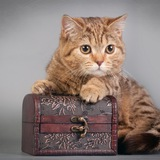

In [5]:
img

CPU

In [6]:
I = np.asarray(img)
IS = I.tolist()

I_g = np.asarray(img)
IS_g = I_g.tolist()

In [7]:
print(len(IS))
print(len(IS[0]))
print(len(IS[0][0]))


160
160
3


РАСЧЁТЫ НА CPU

In [8]:
def cpu_interp():
  for i in range(len(IS)):
    for j in range(0, len(IS[i])*2, 2):
      IS[i].insert(j, IS[i][j])
  for i in range(0, len(IS)*2, 2):
    IS.insert(i, IS[i])

In [9]:
start_cpu = time()
cpu_interp()
end_cpu = time() - start_cpu
print("Время выполнения функции на CPU: ", end_cpu)

Время выполнения функции на CPU:  0.013208150863647461


In [10]:
print(len(IS))
print(len(IS[0]))
print(len(IS[0][0]))

320
320
3


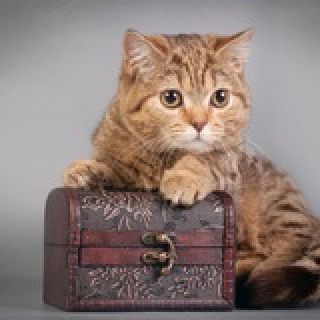

In [11]:
IS_new = np.array(IS)
IS_new = IS_new.astype(np.uint8)
img_new = Image.fromarray(IS_new, 'RGB')
img_new

GPU

In [12]:
h0 = len(IS_g)
h1 = len(IS_g[0])
h2 = len(IS_g[0][0])
print(h0)
print(h1)
print(h2)

160
160
3


РАСЧЁТЫ НА GPU

In [13]:
IS_g_arr = np.array(IS_g)
arr_zer = np.ones([h0*2, h1*2, h2], dtype=int)
arr_zer.shape

(320, 320, 3)

In [20]:
threads_per_block = 256

In [21]:

blocks_per_grid = 1

In [22]:
@cuda.jit
def gpu_interp(array, ones):
  i = cuda.grid(1)
  if i < ones.shape[0]:
    for j in range(array.shape[1]):
      for k in range(3):
        ones[i*2][j*2][k] = array[i][j][k]
        ones[i*2][j*2+1][k] = array[i][j][k]

        ones[i*2+1][j*2][k] = array[i][j][k]
        ones[i*2+1][j*2+1][k] = array[i][j][k]





      

  


    



In [23]:
start_gpu = time()
gpu_interp[blocks_per_grid, threads_per_block](IS_g_arr, arr_zer)
end_gpu = time() - start_gpu


In [24]:
arr_zer

array([[[109, 109, 111],
        [109, 109, 111],
        [109, 109, 111],
        ...,
        [118, 118, 120],
        [117, 117, 119],
        [117, 117, 119]],

       [[109, 109, 111],
        [109, 109, 111],
        [109, 109, 111],
        ...,
        [118, 118, 120],
        [117, 117, 119],
        [117, 117, 119]],

       [[110, 110, 112],
        [110, 110, 112],
        [110, 110, 112],
        ...,
        [119, 119, 121],
        [119, 119, 121],
        [119, 119, 121]],

       ...,

       [[111, 112, 116],
        [111, 112, 116],
        [111, 112, 116],
        ...,
        [102, 100, 105],
        [101,  99, 102],
        [101,  99, 102]],

       [[110, 111, 115],
        [110, 111, 115],
        [110, 111, 115],
        ...,
        [106, 101, 105],
        [105, 100, 104],
        [105, 100, 104]],

       [[110, 111, 115],
        [110, 111, 115],
        [110, 111, 115],
        ...,
        [106, 101, 105],
        [105, 100, 104],
        [105, 100, 104]]

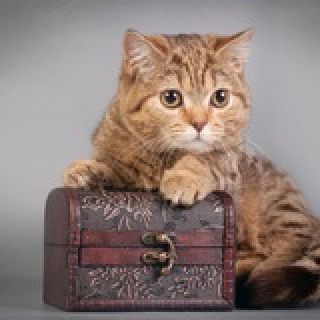

In [25]:
arr_zer = arr_zer.astype(np.uint8)
gpu_img = Image.fromarray(arr_zer, 'RGB')
gpu_img